In [2]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
#import scipy as sp
#import scipy.interpolate
#import scipy.ndimage
#from tqdm import tqdm_notebook
import IPython.display
#from scipy.io import loadmat
#from dask.distributed import Client
import cartopy.feature as cft
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')
import sys, os
import matplotlib
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
from collections import OrderedDict
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '025deg_abs', '01deg']


In [3]:
font={'family':'normal',
     'weight':'bold',
     'size':16}
matplotlib.rc('font',**font)

cmp = plt.get_cmap('nipy_spectral')
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)
clev = np.arange(-0.03,0.03,0.005)

In [4]:
session = cc.database.create_session()

In [5]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [6]:
def wind_stress(ekey,t):
    e = exptdata.exptdict[ekey]
    taux=cc.querying.getvar(e['expt'],'tau_x',session,
                       n=e['n_files'],offset=e['offset']).sel(time=t)
    tauy=cc.querying.getvar(e['expt'],'tau_y',session,
                       n=e['n_files'],offset=e['offset']).sel(time=t)
    return taux,tauy

In [7]:
t=slice('1960-01-01','2018-01-01')
taux,tauy = wind_stress('025deg',t)
tauxabs,tauyabs = wind_stress('025deg_abs',t)

In [7]:
diffx=taux.mean('time')-tauxabs.mean('time')

### relative changes in wind stress 
\begin{equation}
\frac{\tau_{rel}-\tau_{abs}}{\tau_{abs}}
\end{equation}

In [8]:
tauxdif=taux.mean('time')-tauxabs.mean('time')
tauydif=tauy.mean('time')-tauyabs.mean('time')

In [9]:
warnings.filterwarnings('ignore')
meantxabs=tauxabs.mean('time')
meant=meantxabs.values
meant[abs(meant)<0.01]=np.nan
meantxabs=xr.DataArray(meant,coords=tauxdif.coords)
taux_relchg=tauxdif/meantxabs

In [10]:
warnings.filterwarnings('ignore')
meantyabs=tauyabs.mean('time')
m=meantyabs.values
m[abs(m)<0.01]=np.nan
meantyabs=xr.DataArray(m,coords=tauydif.coords)
tauy_relchg=tauydif/meantyabs

plotting tauxdif
plotting tauydif
plotting taux_relchg
plotting tauy_relchg


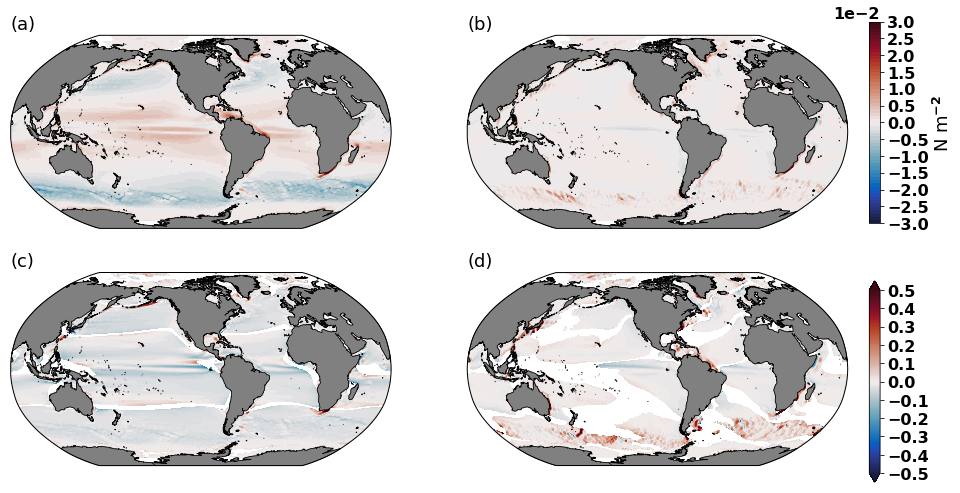

In [26]:
plt.figure(figsize=(15,8))
clev = np.arange(-0.03,0.031,0.001)
clev1=np.arange(-0.5,0.51,0.01)
print('plotting tauxdif')
ax1 = plt.subplot(2,2,1,projection=ccrs.Robinson(central_longitude=-100))
ax1.coastlines(resolution='50m')
ax1.add_feature(land_50m)
p1 = tauxdif.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

print('plotting tauydif')
ax2 = plt.subplot(2,2,2,projection=ccrs.Robinson(central_longitude=-100))
ax2.coastlines(resolution='50m')
ax2.add_feature(land_50m)
p1 = tauydif.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(b)',loc='left',fontsize=18)

print('plotting taux_relchg')
ax3 = plt.subplot(2,2,3,projection=ccrs.Robinson(central_longitude=-100))
ax3.coastlines(resolution='50m')
ax3.add_feature(land_50m)
p3 = taux_relchg.plot.contourf(cmap=cm.cm.balance,levels=clev1,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(c)',loc='left',fontsize=18)

print('plotting tauy_relchg')
ax4 = plt.subplot(2,2,4,projection=ccrs.Robinson(central_longitude=-100))
ax4.coastlines(resolution='50m')
ax4.add_feature(land_50m)
p4 = tauy_relchg.plot.contourf(cmap=cm.cm.balance,levels=clev1,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(d)',loc='left',fontsize=18)

ax5 = plt.axes([0.92,0.55,0.01,0.35])
cb = plt.colorbar(p1,cax=ax5,orientation='vertical')
cb.ax.set_ylabel('N m$^{-2}$',fontsize=18)
cb.set_ticks(np.arange(-3e-2,3.1e-2,5e-3))
cb.formatter.set_powerlimits((0, 0))
cb.update_ticks()

ax6 = plt.axes([0.92,0.1,0.01,0.35])
cb1 = plt.colorbar(p4,cax=ax6,orientation='vertical')
cb1.set_ticks(np.arange(-5e-1,5.1e-1,1e-1))
#cb1.formatter.set_powerlimits((0, 0))
#cb1.update_ticks()
#cb.ax.set_ylabel('SST (°C)')

savefigure('wscomp')

## Wind stress curl

In [27]:
grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output110/ocean/ocean_grid.nc')
dxt=grid.dxt
dxtnew=dxt.values[1:,1:]
dyt=grid.dyt
dytnew=dyt.values[1:,1:]

In [28]:
def WSC(ekey,t):
    e = exptdata.exptdict[ekey]
    taux=cc.querying.getvar(e['expt'],'tau_x',session,
                       n=e['n_files'],offset=e['offset']).sel(time=t).mean('time')
    tauy=cc.querying.getvar(e['expt'],'tau_y',session,
                       n=e['n_files'],offset=e['offset']).sel(time=t).mean('time')
    # dtaux/dy
    tauxnew=taux.values
    dtaux=tauxnew[:,1:]-tauxnew[:,0:-1]
    dtauxmean=1/2*(dtaux[1:,:]+dtaux[0:-1,:])
    dtaux_dy=xr.DataArray(dtauxmean/dytnew,coords=[dyt['yt_ocean'][1:],dyt['xt_ocean'][1:]])
    #dtauy/dx
    tauynew=tauy.values
    dtauy=tauynew[1:,:]-tauynew[0:-1,:]
    dtauymean=1/2*(dtauy[:,1:]+dtauy[:,0:-1])
    dtauy_dx=xr.DataArray(dtauymean/dxtnew,coords=[dxt['yt_ocean'][1:],dyt['xt_ocean'][1:]])
    wsc=dtauy_dx-dtaux_dy
    return wsc

In [29]:
warnings.filterwarnings('ignore')
wsc=WSC('025deg',t)#relative wind wind stress curl
wsc_abs=WSC('025deg_abs',t)# absolute wind stress curl

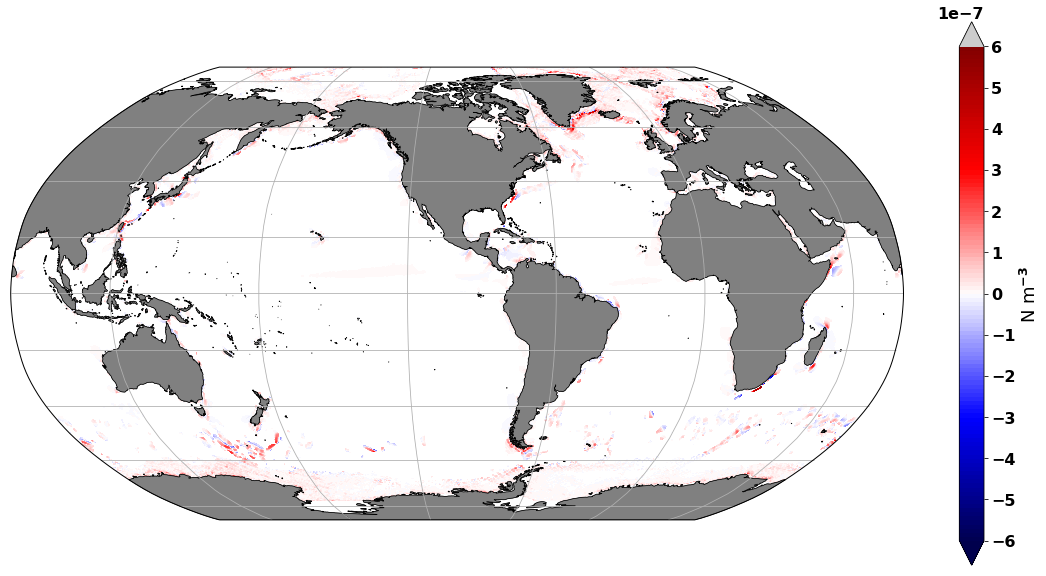

In [33]:
#plot difference of wind stress curl between absoulte and relative wind experiment
clev2 = np.arange(-6e-7,6.1e-7,0.1e-7)
fig =plt.subplots(figsize=(20,10))
ax = plt.subplot(1,1,1,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = (wsc-wsc_abs).plot.contourf(cmap='seismic',levels=clev2,add_colorbar=False,
                                extend='both',transform=ccrs.PlateCarree())

p1.cmap.set_over(color=cmp(255), alpha=None)
cb = plt.colorbar(p1,orientation='vertical')
cb.set_ticks(np.arange(-6e-7,6.1e-7,1e-7))
cb.ax.set_ylabel('N m$^{-3}$',fontsize=18)
plt.title('')
#plt.title('(a) ACCESS-OM2')
savefigure('wsc_diff')

In [30]:
#relative change of wind stress curl
warnings.filterwarnings('ignore')
wsc_abs_v=wsc_abs.values
wsc_abs_v[abs(wsc_abs_v)<1e-7]=np.nan
wsc_abs_4cp=xr.DataArray(wsc_abs_v,coords=wsc_abs.coords)

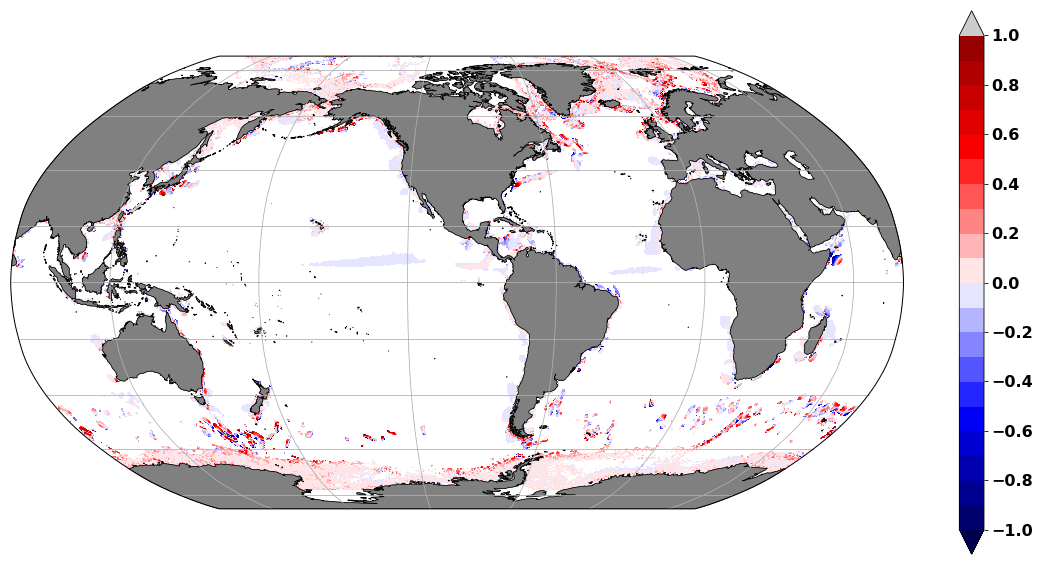

In [32]:
# plot relative changes of wind stress curl
clev2 = np.arange(-1,1.1,0.1)
fig =plt.subplots(figsize=(20,10))
ax = plt.subplot(1,1,1,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = ((wsc-wsc_abs)/wsc_abs_4cp).plot.contourf(cmap='seismic',levels=clev2,add_colorbar=False,
                                extend='both',transform=ccrs.PlateCarree())

p1.cmap.set_over(color=cmp(255), alpha=None)
cb = plt.colorbar(p1,orientation='vertical')
cb.set_ticks(np.arange(-1,1.1,0.2))
#cb.ax.set_ylabel('N m$^{-3}$',fontsize=18)
plt.title('')
savefigure('relchg_wsc')